In [ ]:
import pickle 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from utils import generate_split, to_standard, from_standard

matplotlib.rcParams["figure.dpi"] = 100

In [3]:
#compare the choice of weight-tying in HenonMap
save_path = 'results/'
train_loss = pickle.load(open(f"{save_path}train_loss_layer=2_hid=32_lr=0.0001.pkl", "rb"))
train_loss_tie = pickle.load(open(f"{save_path}train_loss_layer=2_hid=32_lr=0.0001_tie=True.pkl", "rb"))

In [5]:
len(train_loss), len(train_loss_tie)

(12090, 12090)

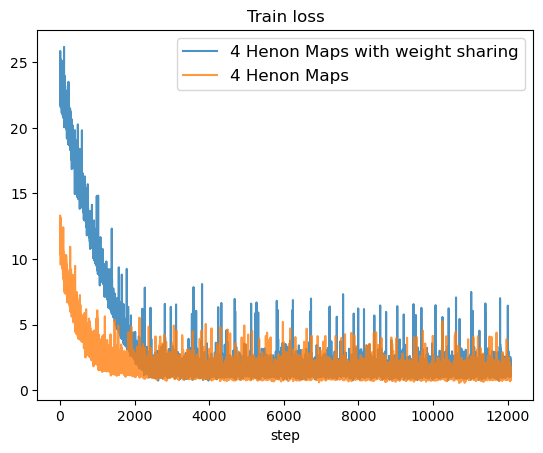

In [13]:
plt.plot(train_loss_tie, alpha=0.8, label="4 Henon Maps with weight sharing")
plt.plot(train_loss, alpha=0.8, label="4 Henon Maps")
plt.xlabel('step')
plt.title("Train loss")
plt.legend(fontsize=12)
plt.show()

### Models
- HenonNet symplectic $T_W$: Sec.1
    - Model predictions $\hat{x}_o, \hat{v}_o = T_W(x, v)$
    - Target $x_o = \sqrt{2J} \sin \omega, v_o = \sqrt{2J} \cos \omega$ from Adrian's action-angle pair
    - Optimize $T_W$ to minimize MSE loss $\ell([\hat{x}_o; \hat{v}_o], [x_o, v_o])$
- HenonNetsupQ sympletic $T_W$ and predictor for target quantity $\xi_Q$: Sec.3
    - Model predictions $$\hat{x}_o, \hat{v}_o = T_W(x, v); \quad \widehat{J} = 0.5(\hat{x}_o^2 + \hat{v}_o^2); \quad \widehat{Q} = \xi_Q(\widehat{J})$$
    - Target $x_o, v_o, Q$
    - Loss $\ell([\hat{x}_o; \hat{v}_o], [x_o, v_o]) + \beta \ell(\widehat{Q}, Q)$

In [143]:
def plot_pred(x_pred, v_pred, Q, title):
    stat_Jth = binned_statistic_2d(x_pred,v_pred,Q,bins=np.linspace(-15, 15, 128))
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.pcolormesh(
        stat_Jth.x_edge,
        stat_Jth.y_edge,
        stat_Jth.statistic.T,
        vmin=0, vmax=0.4
    )
    for r in [2, 4, 6, 8, 10]:
        ax.add_patch(plt.Circle((0, 0), r, facecolor="none", edgecolor="tab:blue", lw=1.5))
    ax.set(xlabel=r"$\sqrt{J_z} \cos(\theta_z)$", ylabel=r"$\sqrt{J_z} \sin(\theta_z)$")
    ax.set_title(title)

def load_data(file_path, data_path):
    #obtain eval set prediction 
    save_file = pickle.load(open(file_path,"rb"))
    x_pred = save_file['x_pred']
    v_pred = save_file['v_pred']
    mean, std = save_file['data_mean_std']
    xv_pred = from_standard(np.concatenate((x_pred,v_pred), axis=-1), mean, std)
    data_dict =  pickle.load(open(data_path, "rb"))
    train_indices, val_indices, test_indices = data_dict['splits']
    Q = data_dict['Q'][val_indices]
    X_o = data_dict['X_o'][val_indices]
    V_o = data_dict['V_o'][val_indices]
    X = data_dict['X'][val_indices]
    V = data_dict['V'][val_indices]
    return xv_pred, X_o, V_o, X, V, Q, save_file['train_loss']

def load_data_supQ(file_path, data_path):
    #obtain eval set prediction 
    save_file = pickle.load(open(file_path,"rb"))
    x_pred = save_file['x_pred']
    v_pred = save_file['v_pred']
    Q_pred = save_file['Q_pred']
    mean, std = save_file['data_mean_std']
    xv_pred = from_standard(np.concatenate((x_pred,v_pred), axis=-1), mean, std)
    data_dict =  pickle.load(open(data_path, "rb"))
    train_indices, val_indices, test_indices = data_dict['splits']
    Q = data_dict['Q'][val_indices]
    X_o = data_dict['X_o'][val_indices]
    V_o = data_dict['V_o'][val_indices]
    X = data_dict['X'][val_indices]
    V = data_dict['V'][val_indices]
    return xv_pred, Q_pred, X_o, V_o, X, V, Q, save_file['train_loss']

#### Results of using HenonNet (sec.1)

In [ ]:
file_path = "results/_layer=4_hid=32_lr=0.01_tie=False_ep=30/save_file.pkl"
data_path = "data_1D_dim=2.pkl"
xv_pred, X_o, V_o, X, V, Q, train_loss = load_data(file_path, data_path)

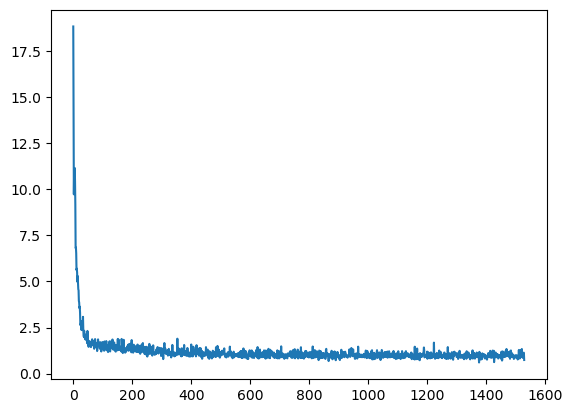

In [ ]:
plt.plot(train_loss)
plt.show()

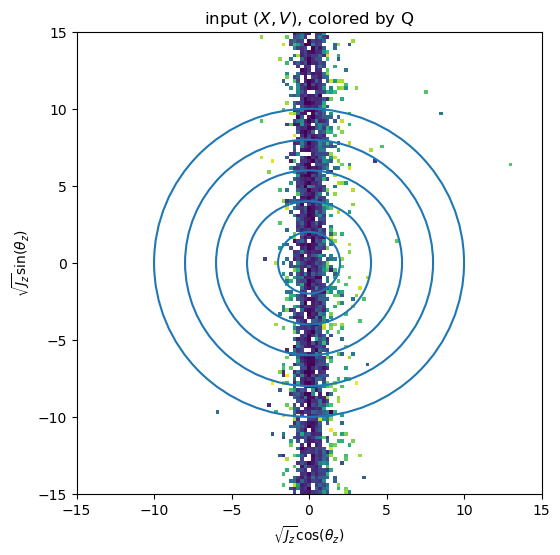

In [ ]:
plot_pred(X, V, Q, title=r'input $(X,V)$, colored by Q')

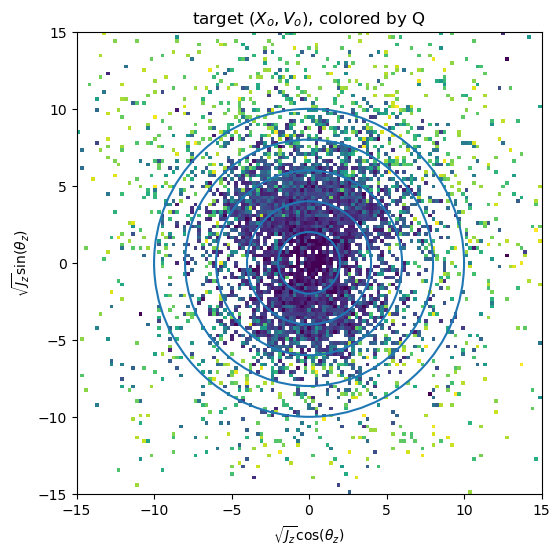

In [ ]:
plot_pred(X_o, V_o, Q, title=r'target $(X_o, V_o)$, colored by Q')

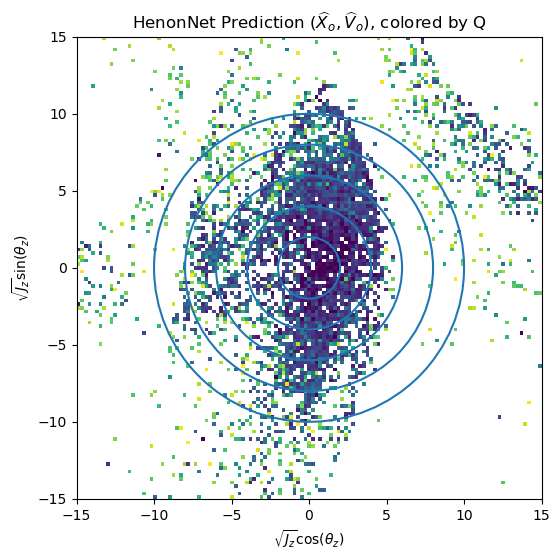

In [ ]:
plot_pred(xv_pred[:,0], xv_pred[:,1], Q, title=r'HenonNet Prediction $(\widehat{X}_o, \widehat{V}_o)$, colored by Q')

#### Results for HenonNetsupQ (Sec.3)

In [154]:

file_path = "results_supQ/_layer=4_hid=32_lr=0.01_tie=False_ep=30_bs=1024/save_file.pkl"
data_path = "data_1D_dim=2.pkl"
xv_pred, Q_pred, X_o, V_o, X, V, Q, train_loss = load_data_supQ(file_path, data_path)

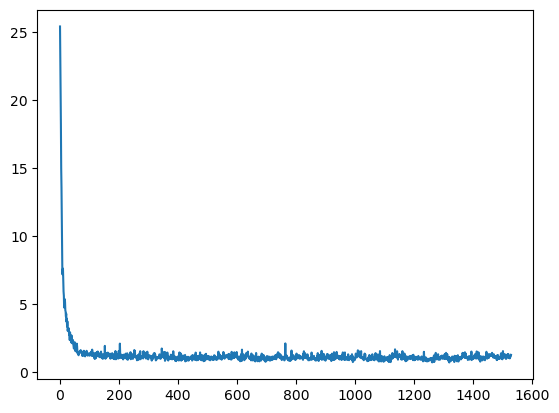

In [155]:
plt.plot(train_loss)
plt.show()

In [156]:
len(xv_pred), len(Q)

(6439, 6439)

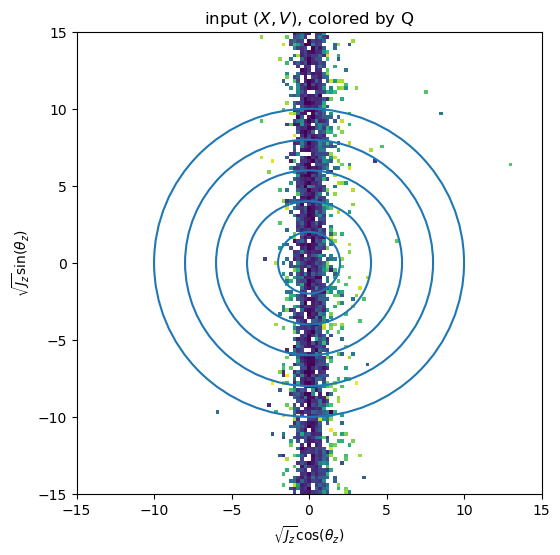

In [157]:
plot_pred(X, V, Q, title=r'input $(X,V)$, colored by Q')

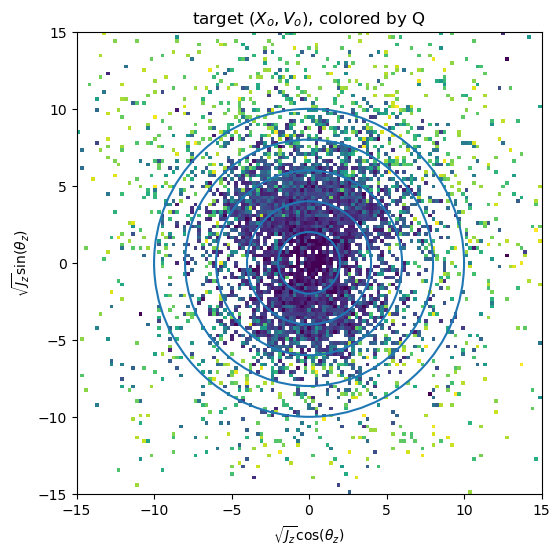

In [158]:
plot_pred(X_o, V_o, Q, title=r'target $(X_o, V_o)$, colored by Q')

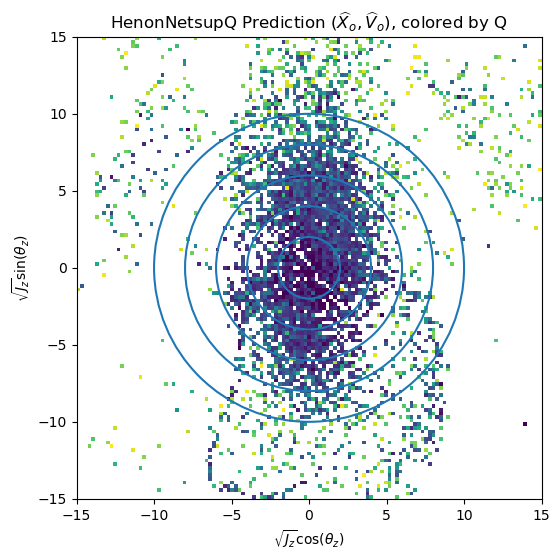

In [159]:
plot_pred(xv_pred[:,0], xv_pred[:,1], Q, title=r'HenonNetsupQ Prediction $(\widehat{X}_o, \widehat{V}_o)$, colored by Q')

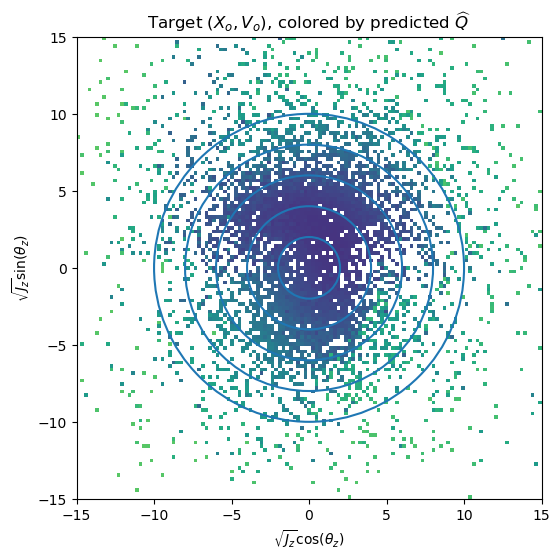

In [140]:
plot_pred(X_o, V_o, Q_pred.flatten(), title=r'Target $(X_o, V_o)$, colored by predicted $\widehat{Q}$')

As shown above:
- Prediction for $Q$ is "easy";
- Prediction for $(x_o, v_o)$ (the symplectic transformed output coordinates) is "hard"